In [1]:
from fastai.vision import *

path = './'

In [79]:
path_og = f'{path}labelled images'
path_lr = f'{path}small-96'
path_mr = f'{path}small-256'
path_cropped = f'{path}labelled images cropped'

il = ImageList.from_folder(path_og)

def crop_and_resize(fn, i, path, size=None):
    dest = path/fn.relative_to(path_og)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    size = size or img.size
    width, height = img.size
    left = width * .2
    right = width * .8
    top = 0
    bottom = right - left
    img = img.crop((left, top, right, bottom))
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=75)

# create smaller image sets the first time this nb is run
sets = [(path_lr, 96), (path_mr, 256)]
for p,size in sets:
    #if not p.exists(): 
        print(f"resizing to {size} into {p}")
        parallel(partial(crop_and_resize, path=p, size=size), il.items)

resizing to 96 into ./small-96


resizing to 256 into ./small-256


In [2]:
fnames = get_image_files(path+'small-96')
fnames[0:10]

[PosixPath('small-96/s12 coley 23.5.jpg'),
 PosixPath('small-96/s12 chad 14.jpg'),
 PosixPath('small-96/s12 christian 16.jpg'),
 PosixPath('small-96/s12 james s 19.jpg'),
 PosixPath('small-96/s12 alex 6.jpg'),
 PosixPath('small-96/s12 grant 10.jpg'),
 PosixPath('small-96/s12 derek 7.jpg'),
 PosixPath('small-96/s12 brandon 19.jpg'),
 PosixPath('small-96/s12 evan 10.jpg'),
 PosixPath('small-96/s12 james t 5.jpg')]

In [3]:
def get_float_labels(filename):
    filename_parts = filename.parts[1].split()
    return float(filename_parts[len(filename_parts)-1].rpartition(".")[0])

In [4]:
labels = []
for fname in fnames:
    label = get_float_labels(fname)
    labels.append(label)
    
labels_avg = np.mean(labels)
labels_std = np.std(labels)
labels_norm = (labels - labels_avg)/labels_std

In [5]:
data_df = pd.DataFrame()
data_df['name'] = fnames
data_df['labels'] = labels_norm

In [6]:
tfms = get_transforms()

In [7]:
data = (ImageList.from_df(data_df, path)
        .split_by_rand_pct(0.3)
        .label_from_df(label_cls=FloatList)
        .transform(tfms)
        .databunch()
        .normalize())

In [8]:
data

ImageDataBunch;

Train: LabelList (77 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: FloatList
-0.04301754,0.20603137,-1.0392132,-0.54111534,-0.9146887
Path: .;

Valid: LabelList (33 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: FloatList
1.3267515,1.1399648,1.0154403,-0.6656398,0.081506915
Path: .;

Test: None

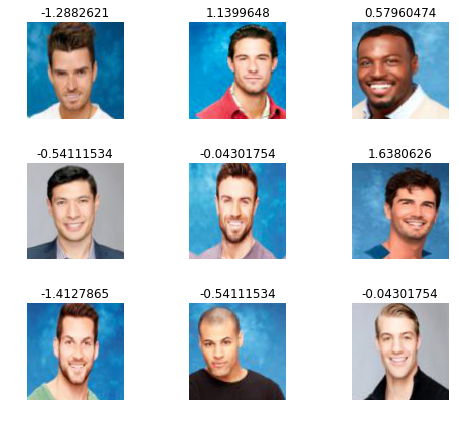

In [9]:
data.show_batch(rows=3, figsize=(7,6))

In [10]:
class L1LossFlat(nn.L1Loss):
    "Mean Absolute Error Loss"
    def forward(self, input:Tensor, target:Tensor) -> Rank0Tensor:
        return super().forward(input.view(-1), target.view(-1))

In [11]:
learn = cnn_learner(data, models.resnet34)
#learn.loss = MSELossFlat
learn.loss = L1LossFlat

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


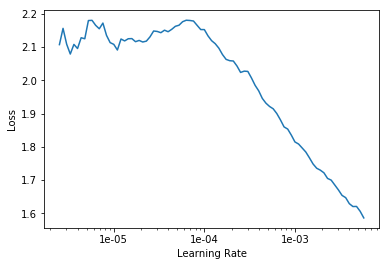

In [12]:
learn.lr_find(start_lr = 1e-6, end_lr = 1e-2)
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(20,slice(1e-4))

epoch,train_loss,valid_loss,time
0,1.976756,2.029864,00:01
1,2.360611,1.844172,00:01
2,2.266827,1.735081,00:01
3,2.282499,1.647062,00:01
4,2.182594,1.605211,00:01
5,2.139919,1.531052,00:01
6,2.075659,1.426719,00:01
7,2.037651,1.333099,00:01
8,2.021558,1.240134,00:01
9,2.035177,1.179477,00:01


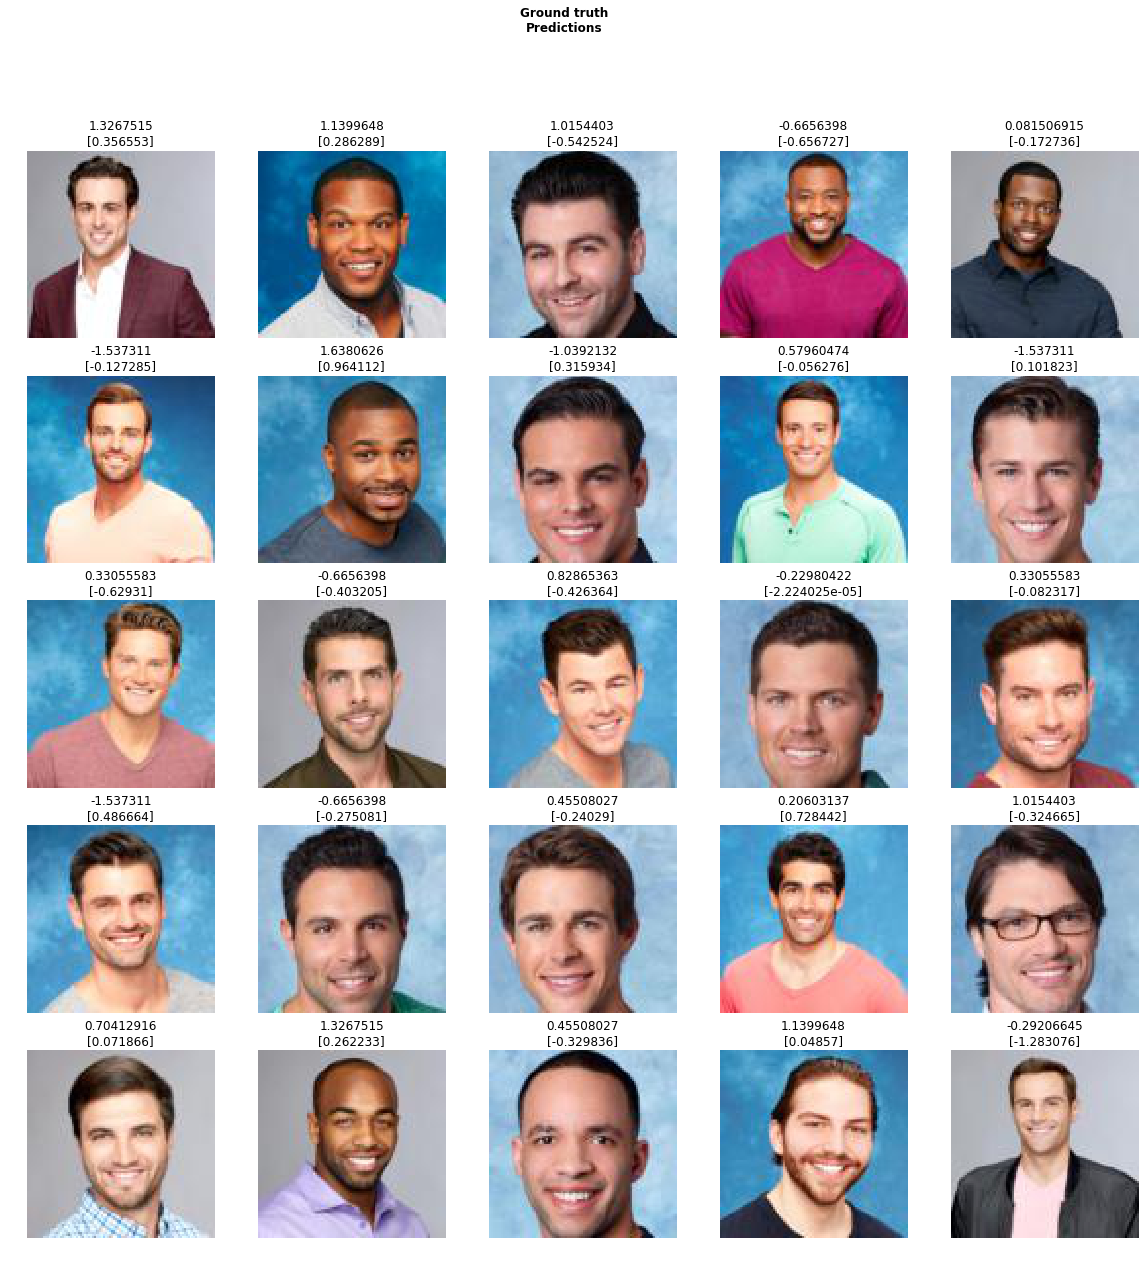

In [15]:
learn.show_results()